# AlexNet

This notebook is going to play around with the AlexNet network, which was considered a major breakthrough in computer vision when published in 2012. See

Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. Commun. ACM 60, 6 (June 2017), 84–90. [https://doi.org/10.1145/3065386](https://doi.org/10.1145/3065386)

In [1]:
# import statements
from letsbuildmodels import devices
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import models
from torchvision.transforms import v2

In [2]:
# Setup
device = devices.get_device()
print(f"Using {device} device")

Using mps device


## The data set

Before we get to AlexNet, we're going to start with a simple data set, much simpler than the one used in AlexNet. The reason for using a different data set for starting is mostly performance. The data set used for AlexNet was quite large, and it's overkill for the initial models we'll build. We'll move to the full data set later, and keep tweaking from there.

Note: there are two downloads you'll need in your working directory, described in the code below.

In [3]:
# Imagenet classes downloaded from
# https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", 'r') as file:
    lines = [line.strip() for line in file]
bee_index = lines.index("bee")
ant_index = lines.index("ant")

print(f"bee_index: {bee_index}")
print(f"ant_index: {ant_index}")

bee_index: 309
ant_index: 310


In [4]:
# Data downloaded from https://www.kaggle.com/datasets/ajayrana/hymenoptera-data
ddir = 'hymenoptera_data'

train_transformers = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transformers = v2.Compose([
    v2.ToImage(),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class TargetTransformer:
    def __call__(self, target):
        one_hot = torch.zeros(1000, dtype=torch.float32)
        if target == 0:
            one_hot[ant_index] = 1.0
        else:
            one_hot[bee_index] = 1.0
        return one_hot


train_dataset = datasets.ImageFolder(
    f"{ddir}/train",
    transform=train_transformers,
    target_transform=TargetTransformer(),
)
test_dataset = datasets.ImageFolder(
    f"{ddir}/val",
    transform=test_transformers,
    target_transform=TargetTransformer(),
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 244
Number of testing samples: 153


## Using the pre-trained model as-is

PyTorch has a built-in AlexNet model. Let's download it, and see how it works as-is.

In [5]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
def test():
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            max_indices = torch.argmax(outputs, dim=1)
            predicted = torch.zeros_like(outputs)
            predicted.scatter_(1, max_indices.unsqueeze(1), 1)            
            total += labels.size(0)
            correct += (predicted == labels).all(dim=1).int().sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.2%}")

test()

Accuracy: 0.00%


## Retraining the model

The pre-trained model is quite useless on the images we gave it. Let's try re-training the model, to see if we can improve it's peformance.

Epoch: 40 / 40 

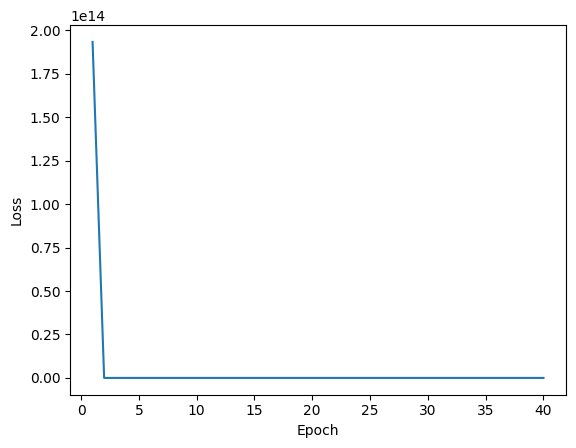

In [7]:
epochs = 40
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
criterion = nn.CrossEntropyLoss()

def train_and_plot(model, train_loader, criterion):
    model.train()

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    x = np.arange(1, epochs + 1)
    y = np.zeros(epochs)

    print("Epoch:  0 / 40 ", end="\r")

    last_loss = float('inf')
    
    for epoch in range(epochs):
        epoch_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        y[epoch] = epoch_loss
        print(f"Epoch: {epoch + 1:2} / 40", end = "\r")

        if epoch_loss >= last_loss:
            # Reduce learning rate by a factor of 10 if loss didn't improve
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10
        last_loss = epoch_loss

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.show()

train_and_plot(model, train_loader, criterion)

Now let's see how it does.

In [8]:
test()

Accuracy: 54.25%


Clearly a small amount of retraining made a big performance boost.